

### General Hints:

* When in doubt, use `float()` 
* When in doubt, make sure your probability functions sum to one (in the right way).
* If problems arise, read the descriptions in the cells. They might give you clues. 
* Don't worry about precision/rounding (i.e., if your answer is supposed to be 1.0, but you get 1.000000492, that's okay)

### The data

* For the questions below, you are going to need some data. 
* The data is the proper name / type data that you have used before. 
* The cell below reads in the data for you. It's going to read in `pnp-train.txt` into a pandas data frame where one column will be the proper name **type** and then another column with the proper **name** itself. 
* I'm then going to lowercase and split the values in the name column and store those back into the name column.
* Note that each row of the data['name'] column contains a list of strings (i.e., words). If that column doesn't contain a list of words, some of the functions below in later cells that I give you won't work. So whatever you do to that column, make sure it's a list of strings (i.e., words).

In [1]:
import pandas as pd

data = pd.read_csv('pnp-train.txt',names=['type','name'], delimiter='\t', encoding='ISO-8859-1')
data['name'] = data['name'].map(lambda x: x.strip().lower().split())

data[:10]

,type,name
0,drug,[dilotab]
1,movie,"[beastie, boys:, live, in, glasgow]"
2,person,"[michelle, ford-eriksson]"
3,place,[ramsbury]
4,place,"[market, bosworth]"
5,drug,"[cyanide, antidote, package]"
6,person,"[bill, johnson]"
7,place,[ettalong]
8,movie,"[the, suicide, club]"
9,place,[pézenas]


### 1. List the names of all the possible types

* You may want to keep this list for later

In [2]:
types = set(data['type'])

types

{'company', 'drug', 'movie', 'person', 'place'}

### 2. Plot the frequencies of the possible types

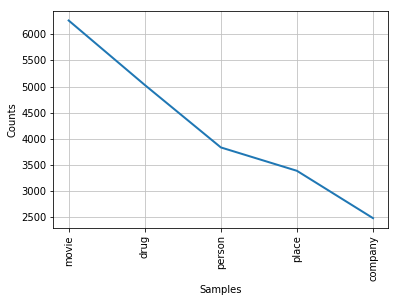

In [3]:
%matplotlib inline
import nltk

nltk.FreqDist(data['type']).plot()

### 3. Write a probability function $Ptype(T)$ that is a probability distribution over the types

In [4]:
# counter option
import collections as c

type_count = c.Counter(data['type'])

def Ptype(T=''):
    global type_count
    global data
    return type_count[T] / float(len(data))

In [5]:
# freqdist option
import nltk

tdist = nltk.FreqDist(data['type'])

def Ptype(T=''):
    p = tdist.freq(T)
    return p

In [6]:
import numpy as np

np.sum(Ptype(T=t) for t in types)

1.0

### 4. Compute the entropy for $Ptype(T)$

In [7]:
import math
import numpy as np

- np.sum([Ptype(T=t) * math.log(Ptype(T=t)) for t in types])

1.5605005599132853

### 5. Write a probability function $Pword(W)$ for all the words

* Be sure to *not* perform the counting *within* the function. This function will be called hundreds of times further below, so you want to be sure it runs fairly fast. Do all of your counting once. 

In [8]:
# counter option
word_count = c.Counter(w for line in data['name'] for w in line)
total_word_count = sum(word_count.values())

def Pword(W=''):
    global name_count
    global total_word_count
    if W not in word_count: return 0.000001
    return word_count[W] / total_word_count

In [9]:
# freqdist option
wdist = nltk.FreqDist(w for line in data['name'] for w in line)

def Pword(W=''):
    p = wdist.freq(W)
    if p == 0: return 0.000001
    return p

In [10]:
s = [w for line in data['name'] for w in line]

np.sum(Pword(W=w) for w in set(s))

1.0000000000002933

### 6. Write a probability function for $Pwt(W|T)$ for the words given the types

In [11]:
# counter option
counters = {}
total_counts = {}
for t in types:
    sub = data[data['type'] == t]
    counters[t] = c.Counter(w for line in sub['name'] for w in line)
    total_counts[t] = sum(counters[t].values())
    
def Pwt(W='', T=''):
    global counters
    global total_counts
    if W not in counters[T]: return 0.000001 
    return counters[T][W] / total_counts[T]
    

In [12]:
s = set(w for line in sub['name'] for w in line)

np.sum(Pwt(W=l, T=t) for l in s)

1.0000000000000207

### 7. Using your $Ptype(T)$, $Pword(W)$, and $Pwt(W|T)$ functions and knowledge about probability theory, write a function for $Ptw(T|W)$.

* What is the name of the formula/rule that you used?

In [13]:
def Ptw(T='', W=''):
    return Pwt(W=W, T=T) * Ptype(T=T) / Pword(W=W)

Below is a cell for a function that I am going to give you: $P(T|N)$ which computes:

### $$ P(T|N) = Ptw(T|W_1)  Ptw(T|W_2)  ... Ptw(T|W_n) $$

That is, given a list of words in a name $N$, it calls your function $Ptw(T|W)$ for each word and multiplies those results together. Be sure to run this cell. 

In [14]:
import numpy as np

def P(T='',N=''):
    return np.prod([Ptw(T=T, W=w) for w in N])

## 8. Does the $P(T|N)$ function make any indepdence assumptions? If so what?

* no code for this question; answer as a markdown cell

* Yes, it assumes each word computed by Ptw(T|W) is independent of each other. 

Now, run the next cell. It will call $P(T|N)$ for a test name for each type, which will in turn call your functions. You should see a probability for each type.

When you run it, you might get a ZeroDivisionError. That happens because your $Pword(W)$ function returns 0 for some words. You need to fix this problem (i.e., perform a simple smoothing by returning 0.000001 when a word isn't found).

Make sure you re-run your cell that contains the $Pword(W)$ function!

When you run the cell below again, you might find that the $P(T|S)$ returns zeros for most of the types. That's because your $Pwt(W|T)$ function also needs to do some smoothing. You need to fix this (you can do some simple smoothing by returning 0.000001 when a word isn't found as part of a type). 

Make sure you re-run your cell that contains the $Pwt(W|T)$ function!

After you've done that, run the below cell again. You know you're on the right track when all the probabilities are above zero. 

In [15]:
name = "inception".split()
probs = [(t, P(T=t, N=name)) for t in types]
probs

[('place', 0.16137326793962192),
 ('person', 0.18265796866815867),
 ('movie', 0.29817627732012764),
 ('drug', 0.23951240417122993),
 ('company', 0.11828008190086187)]

### 9. Now you need to load in `pnp-test.txt` and store it it into a dataframe called `test`.  

* You will need to perform `lower()` and `split()` on the `name` column (store the result back into the `name` column).

In [16]:
test = pd.read_csv('pnp-test.txt',names=['type','name'], delimiter='\t', encoding='ISO-8859-1')
test['name'] = test['name'].map(lambda x: x.strip().lower().split())

Now the critical moment. Run the next cell. It calls $P(T|S)$ which calls your functions for each name in `test`. The function returns a probability for each of the types. The cell then finds the type that has the highest probability and then checks to see if that matches the correct type. If it does, then it increments the `cor` counter. 

When done, it outputs the result of dividing the `cor` counter by the number of names given in the `test` data frame. This result is the accuracy of the probabilistic function to predict the type, given the words in the names. If the accuracy is lower than 60%, then something is wrong with one (or more) of your functions above. Please check them to make sure they are correct. Keep updating your cells and running the cell below until you get above 60%. 

In [17]:
types = set(data['type'])

cor = 0.0
for typ,name in zip(test['type'],test['name']):
    probs = [(t, P(T=t, N=name)) for t in types]
    m = ('',0.0)
    for t,p in probs:
        if p > m[1]: m = (t,p)
    if typ == m[0]: cor +=1.0

cor / float(len(test))

0.6792380952380952

If you got over 60% then your functions are (more or less) correct. Congratulations, you wrote your first classifier from scratch. This is called a Naive Bayes Classifier. You have taken your first step into machine learning and NLP. 

We can compare your classifier to the Naive Bayes's Classifier which is part of NLTK. Run the next two cells and compare the accuracy to your accuracy. 

In [18]:
# compare to NLTK's NB Classifier
import nltk
import collections as c
import numpy as np
from nltk.classify.naivebayes import NaiveBayesClassifier

#train
data['feats'] = data['name'].map(lambda x: c.Counter(x))
train_data = list(zip(data['feats'], data['type']))
classifier = NaiveBayesClassifier.train(train_data)

In [19]:
#test
test['feats'] = test['name'].map(lambda x: c.Counter(x))
test_data = list(zip(test['feats'], test['type']))
nltk.classify.util.accuracy(classifier, test_data)

0.6693333333333333

### 10. For this exam, you are required to complete one of the *choose your own adventure* questions below.

### Choose your own adventure option 1: Remove all the stop words from the names


* The stopwords are stored in the list below called sw. 
* You need to store the result of the operation in data['name'] again as a list (or the above functions won't work)
* You will need to apply this to both the `data` and the `test` dataframes
* Which cells did you have to re-run in order for the changes to take effect?
* How did the accuracy of your classifier and the NLTK classifier change?

In [19]:
from nltk.corpus import stopwords
sw = stopwords.words('english')

sw[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your']

In [20]:
data['name'] = data['name'].map(lambda x: [j for j in x if j not in sw])
test['name'] = test['name'].map(lambda x: [j for j in x if j not in sw])

### Choose your own adventure option 2: Perform stemming or lemmatization on all the words in the names
 
* The stemmer object is given for you. You can call `stemmer.stem('word')` on any word string. 
* Whatever you do, you need to store your result in data['name'] again as a list (or the above functions won't work)
* Remember that this needs to be done for both data and the test dataframes.
* Which cells did you have to re-run in order for the changes to take effect?
* How did the accuracy of your classifier and the NLTK classifier change?

In [21]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

In [22]:
data['name'] = data['name'].map(lambda x: [stemmer.stem(j) for j in x])
test['name'] = test['name'].map(lambda x: [stemmer.stem(j) for j in x])